In [1]:
# from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import random
import scipy
from scipy.optimize import differential_evolution, basinhopping, linprog
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
import time
import warnings
logger = tf.get_logger()
print(scipy.__version__) # 1.9.3
os.environ['KMP_DUPLICATE_LIB_OK']='True'

1.9.3


In [2]:
logging.basicConfig(encoding='utf-8', level=logging.INFO,
                    force = True)

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class DnnResult():
    def __init__(self, theta, stuck):
        self.theta = theta
        self.stuck = stuck

In [5]:
class ValidationResult():
    def __init__(self, valid, can_add_nodes, contains_extra_nodes):
        self.valid = valid
        self.can_add_nodes = can_add_nodes
        self.contains_extra_nodes = contains_extra_nodes        

In [6]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [7]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [8]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float32')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
#     return np.array([1 for i in range(n)])
    return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/10000) for i in range(n)])
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.debug("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [9]:
def get_result_nodes(theta, alpha = 0.5):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True

def mis_is_valid(G, mis):
    has_extra_nodes = not graph_has_no_edges(G, mis)
    not_connected_nodes_exist = not_connected_nodes_exist_in_G(G, mis)
    return ValidationResult(not has_extra_nodes and not not_connected_nodes_exist,
                            not_connected_nodes_exist, has_extra_nodes)
               
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return mis_is_valid(G, result_nodes).valid

def network(theta,e_n,W_t,b,w_t):
    h = tf.math.multiply(e_n,theta)
    h = tf.linalg.matvec(W_t,h)
    h = tf.add(h,b)
    h = tf.nn.relu(h)
    h = tf.tensordot(w_t,h, 1)
    return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()

def loss(theta,e_n,W_t,b,w_t,h_d):
#     with tf.GradientTape() as tape:
    h1 = tf.math.multiply(e_n,theta)
    h2 = tf.linalg.matvec(W_t,h1)
    h3 = tf.add(h2,b)
    h4 = tf.nn.relu(h3)
    h5 = tf.tensordot(w_t,h4, 1)
    diff = (h5-h_d)**2   
#     logging.debug("Gradient = {}".format(tape.gradient(diff, theta)))
#     logging.debug("Loss = {}".format(diff))
    return diff

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2  

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return DnnResult(theta, False)

def vectors_are_close(a,b):
    norm_diff = np.linalg.norm(a-b)
    return norm_diff < 1e-6 

class MinimizationProblem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, loss_fn, weights):
        self._loss_fn = loss_fn
        self._weights = weights
    
    @property
    def num_constraints(self):
        return len(self._weights.numpy()) * 2
   
    def objective(self):
        return self._loss_fn()
   
    def constraints(self):
        theta = self._weights
        lt_or_eq_one = theta - 1
        gt_or_eq_zero = -theta
        constraints = tf.stack([lt_or_eq_one, gt_or_eq_zero])
        return constraints

def gradient_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    
    
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    var_list = theta
#     problem = MinimizationProblem(local_loss, theta)
    
#     optimizer = tfco.ProxyLagrangianOptimizerV2(
#       optimizer=tf.optimizers.Adam(learning_rate=0.1,),
# #       constraint_optimizer=tf.optimizers.Adam(learning_rate=0.1,),
#       num_constraints=problem.num_constraints)
    
#     var_list = ([theta] + list(problem.trainable_variables) + optimizer.trainable_variables())
    
    solver_stuck = False
    previous_theta = np.copy(theta.numpy())
#     logging.debug("theta = {}".format(theta))
    while not result_is_valid(G, theta) and epoch < max_epochs and not solver_stuck:
#     while epoch < max_epochs and not solver_stuck:
#     while not result_is_valid(G, theta):
#         logging.debug("Epoch = {}".format(epoch))
#         optimizer.minimize(problem, var_list=var_list)
        optimizer.minimize(local_loss, var_list=var_list)
#         logging.debug("theta = {}".format(theta))
#         previous_error = local_loss()
#         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
#         logging.debug("Theta={}".format(theta.numpy()))
#         logging.debug("Previous theta = {}".format(previous_theta))
        if np.allclose(previous_theta, theta.numpy()):
            logging.debug("Solver stuck")
            solver_stuck = True
#         if vectors_are_close(previous_theta,theta.numpy()):
#             logging.debug("Solver approaches plateu.")
#             break
        previous_theta = np.copy(theta.numpy())
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
        logging.debug("dNN solution is correct")
    else:
        logging.debug("dNN solution is not correct")
        if not_connected_nodes_exist_in_G(G, get_result_nodes(theta)):
            logging.debug("Can add more nodes to IS")
        else:
            logging.debug("There are extra nodes in IS")
    if epoch == max_epochs:
        logging.debug("Epochs exceeded maximum")
        
    logging.debug("Total epochs = {}".format(epoch))
    logging.debug("dNN solution lenghth = {}".format(len(get_result_nodes(theta))))
    return DnnResult(theta.numpy(),solver_stuck or epoch == max_epochs)

def train_network(G, max_epochs, method="gradient"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float32')
    e_n = tf.constant(np.ones((n)),dtype = 'float32')
    h_d = tf.constant(-n*n/2,dtype = 'float32') 

    if method == "evolutionary":
        result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    elif method == "mixed":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
        if not result_is_valid(G, result.theta):
            logging.debug("Gradient method did not find solution. Trying evolutionary method...")
            theta = tf.Variable(build_theta(G),
                        trainable=True,
                        dtype = 'float32')
            result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    return result

In [10]:
def graphSets(graph): # Determinative algorithm to check correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [11]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [12]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()
        
def calculate_DNN_result(G, MIS, draw_graph = True):
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['green' if node in MIS else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True, font_color="white") # node lables
        plt.show()

In [13]:
def draw_DNN_result(G, max_epochs = 100,):
    MIS = calculate_large_G(G)
    calculate_DNN_result(G, MIS, draw_graph=True)

In [14]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [15]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [16]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

In [17]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [18]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [19]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [20]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].add(neighbour_i)
                    else:
                        edges[node_i] = {neighbour_i}
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].add(node_i)
                    else:
                        edges[neighbour_i] = {node_i}
    return edges

In [21]:
def find_forbidden_edges(G, R, independent_sets):
#     logging.info("independent_sets={}".format(independent_sets))
    forbidden = []
    for u, edges in R.items():
        if u in independent_sets:
            for v in edges:
                if v in independent_sets:
                    forbidden.append((u, v))
#     logging.info("F={}".format(forbidden))
    return forbidden

In [22]:
def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

In [23]:
def collect_communities_to_map(communities):
    new_com = {}
    index = 0
    for com in communities:
        new_com[index] = com
        index+=1
    return new_com

In [24]:
def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1
    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [25]:
def node_is_new_candidate(G, node, mis):
    for w in G.neighbors(node):
        neighbors_in_mis_count = 0
        if w not in mis:
            for n_w in G.neighbors(w):
                if n_w in mis:
                    neighbors_in_mis_count += 1
                    if neighbors_in_mis_count == 2:
                        break
            if neighbors_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

In [26]:
def get_node_with_most_occurences(F):
    count_dict = dict()
    for edge in F:
        for node in edge:
            if node in count_dict:
                count_dict[node]+=1
            else:
                count_dict[node]=0
    maximum = 0
    max_node = None
    for node in count_dict:
        if count_dict[node] > maximum:
            max_node = node
    return node

In [27]:
def replace_node_if_possible(G,F,mis,node):
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        logging.debug("mis = {}".format(mis))
        logging.debug("Node {} can be replaced with {}".format(node, new_node))
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 

In [28]:
def replace_forbiden_nodes(G,R,F,mis):
    logging.debug("Replacing forbiden nodes")
    while len(F) > 0:
#         logging.debug("F = {}".format(F))
        replaced = False
        for edge in F:
            for node in edge:
                replaced = replace_node_if_possible(G,F,mis,node)
                if replaced:
                    break
            if replaced:
                break
        if not replaced:
            node_to_be_removed = get_node_with_most_occurences(F)
            logging.debug("Removing node {}.".format(node_to_be_removed))
            mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

In [29]:
def build_G_from_left_nodes(G, nodes):
    mis_with_neighbours = set()
    for node in nodes:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

In [30]:
def calculate_mis_with_left_nodes(G, mis_list, max_epochs,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.debug("Left nodes = {}".format([left_index_map[node] for node in left_G.nodes()]))
    logging.debug("Left nodes length = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 100:
        mis = calculate_large_G(left_G, max_epochs)
    elif len(left_G.nodes()) > 0:
        logging.debug("In left_G.nodes()) > 0")
        mis = validate_dnn_result(train_network(left_G, max_epochs,method),left_G)
    else:
        mis = {}
    mis_correct = [left_index_map[node] for node in mis]
    logging.debug("mis of left nodes = {}".format(mis_correct))
    mis_final = mis_list.union(mis_correct)
    return mis_final

In [31]:
def build_U_from_IS(_lambda, IS,G,):
    if len(IS) == 0:
        return []
    degree_list_ascending = [(G.degree(node),node) for node in IS]
    degree_list_ascending.sort(key=lambda pair: pair[0])
    return [pair[1] for pair in degree_list_ascending[:min(_lambda, len(IS))]]

In [48]:
def validate_dnn_result(dnn_result, G):
#     if True:
    if dnn_result.stuck:
        if True:
#         if len(G.edges()) < 50:
            logging.debug("Solver stuck. Using local search...")
#             dict_G = nx.to_dict_of_lists(G)
#             mis = graphSets(dict_G)
            mis = local_improvement(G,[0])
#             logging.debug("Local search mis length = {}".format(len(mis)))
            logging.debug("Local search mis length = {}".format(len(mis)))
#             
        else:
            communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution = 1.3, seed=seed))
            if len(communities) > 1:
                logging.debug("Solver stuck. Too many edges to process for local search. Trying split graph to communities...")
                mis = calculate_large_G(G, resolution = 1.3)
            else:
                logging.warning("Solver stuck. Too many edges to process for local search in 1 community. Picking any IS...")
                mis = nx.maximal_independent_set(G)
            logging.debug("validate_dnn_result:IS length = {}".format(len(mis)))
        dnn_result_nodes = get_result_nodes(dnn_result.theta)
        if len(dnn_result_nodes) > len(mis) and result_is_valid(G, dnn_result.theta):
            return dnn_result_nodes
        else:
            return mis
    else:
        theta_for_small_G = dnn_result.theta
        mis = get_result_nodes(theta_for_small_G)
#         mis = local_improvement(G,mis)
        return mis

In [33]:
def try_remove_nodes_with_small_degree(I, G, max_epochs, method):
    _lambda = 5
    I_star = I
    logging.debug("In try_remove_nodes_with_small_degree. I = {}".format(I))
    index = 0
#     graph = build_G_from_nodes(G,I_star)[0]
#     logging.debug("graph_nodes = {}".format(graph.nodes()))
#     logging.debug("graph_edges = {}".format(graph.edges()))
#     nx.draw(graph,with_labels = True) # node lables
#     plt.show()
    while True:
        U = build_U_from_IS(_lambda, I_star,G)
        (reduced_G,index_map, node_map) = build_G_from_left_nodes(G, U)
        if len(reduced_G.nodes()) < 20:
            break
        if index == 0:
            logging.debug("Trying to calculate G removing nodes with small degress")
        index+=1
        logging.debug("Removed nodes = {}".format(U))
        logging.debug("G_nodes={}".format(G.nodes()))
        logging.debug("new_small_G_nodes={}".format({index_map[node] for node in reduced_G.nodes()}))
        dnn_result = train_network(reduced_G, max_epochs,method)
        mis_correct = {index_map[node] for node in validate_dnn_result(dnn_result, reduced_G)}
        I = set(I).union(U)
        if(len(I)>len(I_star)):
            I_star = I
        else:
            I = I_star
        _lambda+=1
    logging.debug("Returning IS with length = {}".format(len(I_star)))
#     graph = build_G_from_nodes(G,I_star)[0]
#     logging.debug("graph_nodes = {}".format(graph.nodes()))
#     logging.debug("graph_edges = {}".format(graph.edges()))
#     nx.draw(graph,with_labels = True) # node lables
#     plt.show()
    return I_star

In [34]:
def log_error_if_mis_is_wrong(G,mis):
    return
    validation = mis_is_valid(G, mis)
    if not validation.valid:
        logger.error("Calculated mis is not correct!")
        logger.debug("mis = {}".format(mis))
        logger.debug("nodes = {}".format(G.nodes()))
        logger.debug("edges = {}".format(G.edges()))
        
        if validation.can_add_nodes:
            logger.error("Can add more nodes!")
        if validation.contains_extra_nodes:
            logger.error("Has edges between nodes!")
    else:
        logger.debug("Calculated mis is correct!")

In [35]:
#"KaMIS/deploy/out.graph"
def write_G_to_file_in_metis_format(G, path):
    fh = open(path, "w")
    fh.write(str(len(G.nodes()))+" "+ str(len(G.edges())) + "\n")
    for node in G.nodes():
        neighbors = []
        for n in G.neighbors(node):
            neighbors.append(n+1)
        neighbors.sort()
        fh.write(" ".join(map(str, neighbors)) + "\n")
    fh.close()
    
def read_redumis_result(path):
    fh = open(path, "r")
    lines = fh.readlines()
    nodes = []
    index = 1
    for line in lines:
        if "1" in line:
            nodes.append(index)
        index+=1
    fh.close()
    return nodes

In [36]:
def nodes_must_be_in_mis(G):
    n = len(G.nodes())
    m = len(G.edges())
    v_0 = [0 for i in range(n)]
    v_1_2 = [0.5 for i in range(n)]
    v_1 = [1 for i in range(n)]
    x_bound = [(0, 1) for i in range(n)]
    c = [-1 for i in range(n)]
    A = []
    b=[]
    for (u,v) in G.edges():
        u = int(u)
        v = int(v)
        if u < v:
            con = [0 for i in range(n)]
            con[u] = 1
            con[v] = 1
            A.append(con)
            b.append(1)
    res = linprog(c, A_ub=A, b_ub=b, bounds=x_bound,method='highs',
#                  integrality = [1 for i in range(n)]
                 )
    nodes_that_must_be_in_mis = set()
    logging.debug("LP result = {}".format(res.x))
    for i in range(n):
        if abs(res.x[i]-1)<0.001:
            nodes_that_must_be_in_mis.add(i)
    return nodes_that_must_be_in_mis

In [37]:
def nodes_that_are_clique(G):
    cliques = set()
    clique_neighbors = set()
    for node in G.nodes():
        if node not in clique_neighbors:
            is_clique = True
            neighbors = set(G.neighbors(node))
            for n1 in neighbors:
                for n2 in neighbors:
                    if n1!=n2 and not G.has_edge(n1,n2):
                        is_clique = False
            if is_clique:
                clique_neighbors.update(neighbors)
                cliques.add(node)
    return cliques

In [38]:
def process_community(G, max_epochs, method, resolution, file_suffix):
    dnn_result = train_network(G, max_epochs,method)
    mis = validate_dnn_result(dnn_result, G)
    logging.debug("MIS length = {}".format(len(mis)))
    log_error_if_mis_is_wrong(G, mis)
    mis = try_remove_nodes_with_small_degree(mis, G, max_epochs, method)
    logging.debug("MIS after removing nodes with small degrees length = {}".format(len(mis)))
    logging.debug("MIS after removing nodes with small degrees in community = {}".format(mis))
    logging.debug("Checking community result is correct...")
    log_error_if_mis_is_wrong(G, mis)
    return mis

In [39]:
def process_main_algo(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find communities solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution, seed=seed))
    logging.debug("Total communities {}".format(len(communities)))
    
    mis_list = set()
    community_index = 1
    write_G_to_file_in_metis_format(G,  "KaMIS/deploy/"+file_suffix)
    
    for com in communities:
        (G_com,index_map, node_map) = build_G_from_nodes(G, communities[com])
        
        logging.debug("Community {} processing...".format(community_index))
        write_G_to_file_in_metis_format(G_com,  "KaMIS/deploy/"+file_suffix+"community_" + str(com) )
        mis_com = process_community(G_com, max_epochs, method, resolution, file_suffix)
        mis_correct = {index_map[node] for node in mis_com}
        logging.debug("MIS in community = {}".format(mis_correct))
        
        mis_list = mis_list.union(mis_correct)        
        community_index += 1
        
    logging.debug("MIS after all communitites processed length = {}".format(len(mis_list)))
    R = find_inter_cluster_edges(G, communities)
#     logging.info("R={}".format(R))
    F = find_forbidden_edges(G, R, mis_list)
    replace_forbiden_nodes(G,R,F,mis_list)
    logging.debug("MIS after forbidden nodes processed length = {}".format(len(mis_list)))
    logging.debug("MIS={}".format(mis_list))
    mis_list = calculate_mis_with_left_nodes(G, mis_list, max_epochs,method)
    logging.debug("MIS after left nodes processed={}".format(mis_list))
    logging.debug("MIS after left nodes processed length = {}".format(len(mis_list)))
    logging.debug("Checking main algo result is correct...")
    log_error_if_mis_is_wrong(G, mis_list)
    return mis_list

In [40]:
def process_lp(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find LP solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    density = nx.density(G)
    logging.debug("Density of G = {}".format(density))
    should_use_lp = density < 0.1
    G_before_LP = G
    if should_use_lp:
        logging.debug("Removing nodes that must be in G according to LP solution")
        nodes_from_lp_solver = nodes_must_be_in_mis(G)
        (G, index_map,_) = build_G_from_left_nodes(G, nodes_from_lp_solver)
        logging.debug("Total nodes removed = {}".format(len(nodes_from_lp_solver)))
        if len(G.nodes()) == 0:
            logging.debug("LP found MIS.")
            log_error_if_mis_is_wrong(G_before_LP, nodes_from_lp_solver)
            logging.debug("Total nodes in MIS = {}".format(len(nodes_from_lp_solver)))
            return nodes_from_lp_solver
    mis_list = process_main_algo(G, max_epochs, method, resolution, file_suffix)
    if should_use_lp:
        mis_list = {index_map[node] for node in mis_list}
        mis_list = mis_list.union(nodes_from_lp_solver)
    logging.debug("MIS after LP nodes processed={}".format(mis_list))
    logging.debug("Checking lp result is correct...")
    log_error_if_mis_is_wrong(G_before_LP, mis_list)
    return mis_list

In [41]:
def process_cliques(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find cliques on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    G_before_cliques = G
    cliques = nodes_that_are_clique(G)
    (G, cliques_index_map,_) = build_G_from_left_nodes(G, cliques)
    logging.debug("Total cliques found = {}".format(len(cliques)))
    logging.debug("cliques = {}".format(cliques))
    if len(G.nodes()) == 0:
        logging.debug("Cliques found MIS.")
        log_error_if_mis_is_wrong(initial_G, cliques)
        logging.debug("Total nodes in MIS = {}".format(len(cliques)))
        return cliques
    mis_list=process_lp(G, max_epochs, method, resolution, file_suffix)
    mis_list = {cliques_index_map[node] for node in mis_list}
    mis_list = mis_list.union(cliques)
    logging.debug("MIS after cliques processed = {}".format(mis_list))
    logging.debug("Checking cliques result is correct...")
    log_error_if_mis_is_wrong(G_before_cliques, mis_list)
    return mis_list

In [42]:
def local_improvement(G, mis):
    should_recalculate = True
    mis_flags = [0 for node in G.nodes()]
    for node in G.nodes():
        if node in mis:
            mis_flags[node] = 1
    while should_recalculate:
        L = [[] for i in range(len(mis_flags))]
        for node in G.nodes():
            if mis_flags[node] == 1:
                for n in G.neighbors(node):
                    tight = 0
                    for k in G.neighbors(n):
                        if mis_flags[k] == 1:
                            tight+=1
                    if tight == 1:
                        L[node].append(n)
                L[node].sort()
#         logging.debug("L={}".format(L))
        
        for x in range(len(mis_flags)):
            if mis_flags[x] == 1:
                replaced = False
                if len(L[x]) > 1:
                    for v in L[x]:
                        for w in L[x]:
                            if v < w and not G.has_edge(v,w):
                                logging.debug("Replacing {} with {} and {}".format(x,v,w))
                                mis_flags[x] = 0
                                mis_flags[v] = 1
                                mis_flags[w] = 1
                                replaced = True
                                break
                        if replaced:
                            break
                    if replaced:
                            break
        if not replaced:
            for node in G.nodes():
                if mis_flags[node] == 0:
                    node_is_free = True
                    for neigh in G.neighbors(node):
                        if mis_flags[neigh] == 1:
                            node_is_free = False
                    if node_is_free:
                        replaced = True
                        logging.debug("Adding {}".format(node))
                        mis_flags[node] = 1
                        break
        should_recalculate = replaced
    new_mis = set()
    for i in range(len(mis_flags)):
        if mis_flags[i]==1:
            new_mis.add(i)
    return new_mis

In [43]:
def calculate_large_G(G, max_epochs = 1000, method='gradient', resolution = 0.8, file_suffix = "graph"):
    logging.debug("Calculating G with nodes = {} edges = {}".format(len(G.nodes()), len(G.edges())))
    mis_list = process_cliques(G, max_epochs, method, resolution, file_suffix)
    logging.debug("Total nodes in MIS={}".format(mis_list))
    log_error_if_mis_is_wrong(G, mis_list)
    logging.debug("Trying local improvement...")
    improved = local_improvement(G,mis_list)
    if len(improved) > len(mis_list):
        logging.debug("Local improvement increased MIS by {}".format(len(improved)-len(mis_list)))
    mis_list = improved
    logging.debug("Nodes in MIS after local improvement={}".format(mis_list))
    logging.debug("Nodes in MIS after local improvement size={}".format(len(mis_list)))
    log_error_if_mis_is_wrong(G, mis_list)
    return mis_list

In [44]:
def test_average_result_on_graph(G, graph_name, iterations = 5):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G)
        logging.info("MIS length = {}".format(len(mis)))
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [45]:
def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    edges = 0
    n = len(graphs)
    for i in range(n):
        logging.info("Processing graph {}...".format(str(i)))
        mis = calculate_large_G(graphs[i],method=method,file_suffix="graph_"+str(i)+"_" )
        logging.info("Total MIS length found = {}".format(len(mis)))
        edges += len(graphs[i].edges())
        sum+=len(mis)
        logging.debug("")
    print("Average edges count = {}".format(edges/n))
    print("Average dNN result = {}".format(sum/n))

In [46]:
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

{0, 3, 4, 7}
Length = 4


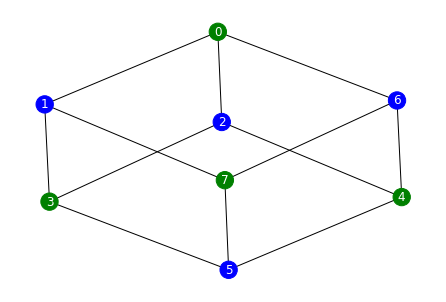

In [47]:
G = build_test_graph1()
calculate_DNN_result(G, calculate_large_G(G), True)

In [337]:
networks = build_n_graphs(20, lambda: nx.erdos_renyi_graph(100,0.1), )

In [338]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 26
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 31
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 29
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 24
INFO:root:Processing graph 10...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 11...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 12...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 13...
INFO:root:Total MIS length found = 28
INFO:root:Proces

Average edges count = 497.55
Average dNN result = 28.25


In [56]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(100,0.2), )

In [57]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 19
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 19
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 19
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 8...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 9...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 18


Average edges count = 982.8
Average dNN result = 18.0


In [58]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.1))

In [59]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 37
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 38
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 5...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 36
INFO:root:Processing graph 8...
INFO:root:Local improvement incr

Average edges count = 2000.8
Average dNN result = 35.9


In [60]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.2))

In [61]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 20
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 20
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 20
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 22
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 3
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 19
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 6...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 21
INFO:root:Processing graph 7...
INFO:roo

Average edges count = 3999.8
Average dNN result = 20.0


In [62]:
def build_stochastic_params(s,p,q = 0.05):
    sizes = []
    probs = []
    for i in range(5):
        sizes.append(s)
        prob = []
        for j in range(5):
            if i != j:
                prob.append(q)
            else:
                prob.append(p)
        probs.append(prob)
    return (sizes, probs)

In [63]:
(sizes, probs) = build_stochastic_params(50,0.1)

In [64]:
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))

In [65]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 56
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 55
INFO:root:Processing graph 2...
INFO:root:Local improvement increased MIS by 5
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 55
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 56
INFO:root:Processing graph 5...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 56
INFO:root:Processing graph 6...
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 51
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 55
INFO:root:Processing graph 8...
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 9...
INFO:root:Local improvement increased MIS by 4
INFO:root

Average edges count = 1865.9
Average dNN result = 55.5


In [66]:
(sizes, probs) = build_stochastic_params(50,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 46
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 42
INFO:root:Processing graph 2...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 4
INFO:root:Total MIS length found = 50
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 52
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 3
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 6
INFO:root:Total MIS length fou

Average edges count = 2474.8
Average dNN result = 45.9


In [67]:
(sizes, probs) = build_stochastic_params(70,0.1)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 62
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 64
INFO:root:Processing graph 2...
INFO:root:Local improvement increased MIS by 6
INFO:root:Total MIS length found = 65
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 63
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 3
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 61
INFO:root:Processing graph 5...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 4
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 2
INFO:ro

Average edges count = 3646.5
Average dNN result = 63.1


In [68]:
(sizes, probs) = build_stochastic_params(70,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 3
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 52
INFO:root:Processing graph 1...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 5
INFO:root:Total MIS length found = 51
INFO:root:Processing graph 2...
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 2
INFO:root:Local improvement increased MIS by 6
INFO:root:Total MIS length found = 53
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:r

Average edges count = 4842.9
Average dNN result = 51.6


In [69]:
networks=build_n_graphs(10, lambda: nx.barabasi_albert_graph(100,45))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 45


Average edges count = 2475.0
Average dNN result = 45.0


In [70]:
networks = build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,100))
networks += build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,90))

In [71]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 10...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 11...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 12...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 13...
INFO:root:Total MIS length found = 90
INFO:r

Average edges count = 9950.0
Average dNN result = 95.0


In [99]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(100,30,0.5))

In [100]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
DEBUG:root:Calculating G with nodes = 100 edges = 2012
DEBUG:root:Trying find cliques on graph with 100 nodes and 2012 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 100 nodes and 2012 edges
DEBUG:root:Density of G = 0.4064646464646465
DEBUG:root:Trying find communities solution on graph with 100 nodes and 2012 edges
DEBUG:root:Total communities 5
DEBUG:root:Community 1 processing...
DEBUG:root:Build network on graph G:Graph with 10 nodes and 32 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[1, 2, 5, 6, 7, 8, 9], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 0 with 1 and 8
DEBUG:root:L=[[], [6], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 3
DEBUG:root:L=[[], [], [], [], [], [], [], [], [

DEBUG:root:Removing node 93.
DEBUG:root:F = [(7, 45), (7, 58), (7, 78), (7, 81), (7, 84), (7, 95), (7, 97), (11, 45), (11, 69), (11, 89), (11, 95), (16, 89), (45, 2), (45, 6), (45, 7), (45, 8), (45, 11), (45, 12), (45, 20), (45, 89), (83, 8), (87, 2), (87, 8), (87, 78), (95, 2), (95, 5), (95, 7), (95, 11), (95, 20), (2, 45), (2, 78), (2, 81), (2, 82), (2, 87), (2, 89), (2, 95), (2, 97), (78, 2), (78, 4), (78, 7), (78, 8), (78, 82), (78, 87), (78, 89), (78, 97), (81, 2), (81, 7), (81, 20), (82, 2), (82, 5), (82, 78), (89, 2), (89, 11), (89, 16), (89, 45), (89, 78), (97, 2), (97, 69), (97, 7), (97, 78), (24, 84), (4, 58), (4, 78), (58, 4), (58, 5), (58, 7), (58, 20), (5, 58), (5, 82), (5, 84), (5, 95), (6, 45), (8, 45), (8, 69), (8, 78), (8, 83), (8, 87), (12, 45), (12, 69), (69, 8), (69, 11), (69, 12), (69, 20), (69, 97), (84, 5), (84, 7), (84, 24), (20, 45), (20, 58), (20, 69), (20, 81), (20, 95)]
DEBUG:root:Removing node 24.
DEBUG:root:F = [(7, 45), (7, 58), (7, 78), (7, 81), (7, 84),

DEBUG:root:Removing node 6.
DEBUG:root:F = [(7, 45), (7, 58), (7, 78), (7, 81), (7, 95), (7, 97), (11, 45), (11, 69), (11, 95), (45, 2), (45, 7), (45, 11), (95, 2), (95, 7), (95, 11), (2, 45), (2, 78), (2, 81), (2, 95), (2, 97), (78, 2), (78, 7), (78, 97), (81, 2), (81, 7), (97, 2), (97, 69), (97, 7), (97, 78), (58, 7), (69, 11), (69, 97)]
DEBUG:root:mis = {2, 69, 7, 10, 11, 78, 16, 81, 24, 95, 97, 45, 58}
DEBUG:root:Node 45 can be replaced with 6
DEBUG:root:F = [(7, 58), (7, 78), (7, 81), (7, 95), (7, 97), (11, 69), (11, 95), (95, 2), (95, 7), (95, 11), (2, 78), (2, 81), (2, 95), (2, 97), (78, 2), (78, 7), (78, 97), (81, 2), (81, 7), (97, 2), (97, 69), (97, 7), (97, 78), (58, 7), (69, 11), (69, 97)]
DEBUG:root:mis = {2, 69, 7, 10, 11, 6, 78, 16, 81, 24, 95, 97, 58}
DEBUG:root:Node 58 can be replaced with 15
DEBUG:root:F = [(7, 78), (7, 81), (7, 95), (7, 97), (11, 69), (11, 95), (95, 2), (95, 7), (95, 11), (2, 78), (2, 81), (2, 95), (2, 97), (78, 2), (78, 7), (78, 97), (81, 2), (81, 7)

DEBUG:root:Replacing 0 with 1 and 2
DEBUG:root:L=[[], [6, 9, 10, 11, 13, 15], [16], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 1 with 6 and 10
DEBUG:root:L=[[], [], [0, 4, 8], [], [], [], [], [], [], [], [5], [], [], [], [], [], [], []]
DEBUG:root:Replacing 2 with 0 and 4
DEBUG:root:L=[[], [], [], [], [11], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 8
DEBUG:root:L=[[], [], [], [], [11], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 5
DEBUG:root:MIS length = 5
DEBUG:root:In try_remove_nodes_with_small_degree. I = {0, 4, 6, 8, 10}
DEBUG:root:Returning IS with length = 5
DEBUG:root:MIS after removing nodes with small degrees length = 5
DEBUG:root:MIS after removing nodes with small degrees in community = {0, 4, 6, 8, 10}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {0, 7, 10, 23, 26}
DEBUG:root:Community 4 processing...
DEBUG:root:Build network on

DEBUG:root:Removing node 27.
DEBUG:root:F = [(2, 78), (78, 0), (78, 2), (78, 7), (78, 10), (78, 12), (78, 18), (78, 34), (78, 69), (78, 77), (5, 82), (82, 0), (82, 5), (82, 7), (82, 16), (82, 18), (82, 23), (82, 34), (82, 70), (6, 34), (6, 69), (6, 72), (6, 50), (6, 84), (6, 61), (34, 0), (34, 6), (34, 7), (34, 10), (34, 15), (34, 16), (34, 18), (34, 23), (34, 26), (34, 50), (34, 69), (34, 70), (34, 78), (34, 82), (50, 6), (50, 15), (50, 16), (50, 23), (50, 26), (50, 34), (50, 61), (50, 84), (61, 6), (61, 7), (61, 10), (61, 15), (61, 23), (61, 50), (61, 69), (61, 84), (69, 6), (69, 7), (69, 12), (69, 15), (69, 18), (69, 23), (69, 34), (69, 61), (69, 77), (69, 78), (72, 0), (72, 6), (72, 15), (72, 18), (72, 23), (84, 6), (84, 12), (84, 50), (84, 61), (84, 70), (7, 34), (7, 61), (7, 69), (7, 77), (7, 78), (7, 82), (12, 69), (12, 77), (12, 78), (12, 84), (77, 7), (77, 12), (77, 26), (77, 69), (77, 78), (15, 34), (15, 50), (15, 61), (15, 69), (15, 70), (15, 72), (70, 15), (70, 16), (70, 18

DEBUG:root:mis = {0, 2, 5, 6, 7, 69, 10, 12, 9, 16, 13, 18, 17, 84, 19, 20, 23, 27, 50}
DEBUG:root:Node 50 can be replaced with 14
DEBUG:root:F = [(6, 69), (6, 84), (69, 6), (69, 7), (69, 12), (69, 18), (69, 23), (84, 6), (84, 12), (7, 69), (12, 69), (12, 84), (18, 69), (23, 69)]
DEBUG:root:mis = {0, 2, 5, 6, 7, 69, 10, 12, 14, 9, 16, 13, 18, 17, 84, 19, 20, 23, 27}
DEBUG:root:Node 69 can be replaced with 3
DEBUG:root:F = [(6, 84), (84, 6), (84, 12), (12, 84)]
DEBUG:root:mis = {0, 2, 3, 5, 6, 7, 10, 12, 14, 9, 16, 13, 18, 17, 84, 19, 20, 23, 27}
DEBUG:root:Node 84 can be replaced with 1
DEBUG:root:MIS after forbidden nodes processed length = 19
DEBUG:root:MIS={0, 1, 2, 3, 5, 6, 7, 10, 12, 14, 9, 16, 13, 18, 17, 19, 20, 23, 27}
DEBUG:root:Left nodes = [4, 8, 11, 15, 21, 22, 24, 25, 26, 28, 29]
DEBUG:root:Left nodes length = 11
DEBUG:root:In left_G.nodes()) > 0
DEBUG:root:Build network on graph G:Graph with 11 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 11
DEBUG:r

DEBUG:root:Total epochs = 123
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[3, 5, 14, 15, 16, 18, 19, 21, 22, 23], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 0 with 3 and 5
DEBUG:root:L=[[], [], [], [16, 19], [], [2, 6, 8, 11, 12, 13], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 5 with 2 and 8
DEBUG:root:L=[[], [], [6, 17, 23], [0, 1, 4, 7, 10], [], [], [], [], [13], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 2 with 6 and 23
DEBUG:root:L=[[], [], [], [], [], [], [17], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 12
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 5
DEBUG:root:MIS length = 5
DEBUG:root:In try_remove_nodes_with_small_degree. I = 

DEBUG:root:Removing node 21.
DEBUG:root:F = [(9, 52), (9, 63), (9, 69), (9, 75), (22, 52), (22, 68), (12, 52), (12, 68), (12, 84), (12, 87), (52, 9), (52, 12), (52, 13), (52, 22), (52, 24), (52, 69), (52, 75), (70, 8), (70, 13), (70, 84), (63, 9), (69, 9), (69, 52), (75, 8), (75, 9), (75, 13), (75, 52), (84, 8), (84, 12), (84, 70), (68, 8), (68, 12), (68, 22), (8, 68), (8, 70), (8, 75), (8, 84), (8, 87), (87, 8), (87, 12), (13, 52), (13, 70), (13, 75), (24, 52)]
DEBUG:root:Removing node 8.
DEBUG:root:F = [(9, 52), (9, 63), (9, 69), (9, 75), (22, 52), (22, 68), (12, 52), (12, 68), (12, 84), (12, 87), (52, 9), (52, 12), (52, 13), (52, 22), (52, 24), (52, 69), (52, 75), (70, 13), (70, 84), (63, 9), (69, 9), (69, 52), (75, 9), (75, 13), (75, 52), (84, 12), (84, 70), (68, 12), (68, 22), (87, 12), (13, 52), (13, 70), (13, 75), (24, 52)]
DEBUG:root:mis = {68, 69, 70, 9, 75, 6, 13, 74, 12, 84, 22, 87, 24, 91, 29, 52, 63}
DEBUG:root:Node 87 can be replaced with 86
DEBUG:root:F = [(9, 52), (9, 6

DEBUG:root:Adding 18
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 19
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 20
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 110
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[3, 6, 8, 9, 11, 12, 13, 15, 16, 18], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 0 with 3 and 6
DEBUG:root:L=[[], [], [], [], [], [], [12], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 1
DEBUG:root:L=[[], [14, 18], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 2
DEBUG:root:L=[[], [14], [7, 8], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 2 with 7 and 8
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 5
DEBUG:root:MIS length = 5
DEBUG:root:In try_remove_nodes_with_small_degree. I = {1, 3, 6, 7, 8}
DEBUG:root:Returning IS with length = 5
DEB

DEBUG:root:Trying local improvement...
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Nodes in MIS after local improvement={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
DEBUG:root:Nodes in MIS after local improvement size=30
INFO:root:Total MIS length found = 30
DEBUG:root:
INFO:root:Processing graph 4...
DEBUG:root:Calculating G with nodes = 100 edges = 2027
DEBUG:root:Trying find cliques on graph with 100 nodes and 2027 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 100 nodes and 

DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 4
DEBUG:root:MIS length = 4
DEBUG:root:In try_remove_nodes_with_small_degree. I = {8, 9, 10, 4}
DEBUG:root:Returning IS with length = 4
DEBUG:root:MIS after removing nodes with small degrees length = 4
DEBUG:root:MIS after removing nodes with small degrees in community = {8, 9, 10, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {25, 11, 20, 23}
DEBUG:root:MIS after all communitites processed length = 28
DEBUG:root:Replacing forbiden nodes
DEBUG:root:F = [(3, 53), (3, 93), (18, 53), (18, 65), (18, 78), (22, 65), (22, 76), (25, 76), (28, 76), (29, 76), (29, 93), (7, 53), (7, 96), (53, 2), (53, 3), (53, 7), (53, 13), (53, 14), (53, 18), (53, 20), (53, 23), (53, 93), (96, 7), (96, 8), (96, 9), (96, 15), (96, 16), (96, 17), (96, 20), (96, 21), (96, 23), (1, 76), (1, 78), (2, 53), (9, 96), (93, 3), (93, 8), (93, 29), (93, 53), (93, 78), (78, 1), (78, 17)

DEBUG:root:Build network on graph G:Graph with 23 nodes and 149 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 118
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[2, 4, 6, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 0 with 2 and 4
DEBUG:root:L=[[], [], [19, 21], [], [14, 15, 22], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 1
DEBUG:root:L=[[], [6, 13], [19], [], [14], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 1 with 6 and 13
DEBUG:root:L=[[], [], [], [], [], [], [8], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 4
DEBUG:root:MIS length = 4
DEBUG:root:In try_remove_nodes_with_small_degree. I = {2, 4, 13

DEBUG:root:Removing node 14.
DEBUG:root:F = [(3, 55), (3, 99), (17, 79), (17, 99), (22, 82), (22, 90), (22, 99), (25, 55), (25, 71), (71, 11), (71, 20), (71, 25), (71, 27), (71, 70), (71, 90), (71, 99), (79, 0), (79, 2), (79, 17), (79, 20), (90, 0), (90, 7), (90, 22), (90, 71), (55, 0), (55, 2), (55, 3), (55, 4), (55, 7), (55, 11), (55, 19), (55, 25), (70, 2), (70, 7), (70, 27), (70, 71), (99, 3), (99, 11), (99, 17), (99, 22), (99, 71), (19, 55), (2, 55), (2, 70), (2, 79), (2, 82), (20, 71), (20, 79), (82, 2), (82, 11), (82, 22), (82, 27), (11, 55), (11, 71), (11, 82), (11, 99), (27, 70), (27, 71), (27, 82), (0, 55), (0, 79), (0, 90), (4, 55), (7, 70), (7, 55), (7, 90)]
DEBUG:root:mis = {0, 2, 3, 4, 70, 71, 7, 6, 11, 13, 79, 17, 82, 19, 20, 22, 24, 25, 90, 27, 99, 55}
DEBUG:root:Node 99 can be replaced with 14
DEBUG:root:F = [(3, 55), (17, 79), (22, 82), (22, 90), (25, 55), (25, 71), (71, 11), (71, 20), (71, 25), (71, 27), (71, 70), (71, 90), (79, 0), (79, 2), (79, 17), (79, 20), (90, 

DEBUG:root:MIS length = 5
DEBUG:root:In try_remove_nodes_with_small_degree. I = {3, 6, 7, 8, 9}
DEBUG:root:Returning IS with length = 5
DEBUG:root:MIS after removing nodes with small degrees length = 5
DEBUG:root:MIS after removing nodes with small degrees in community = {3, 6, 7, 8, 9}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {6, 17, 18, 22, 23}
DEBUG:root:Community 2 processing...
DEBUG:root:Build network on graph G:Graph with 19 nodes and 105 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 102
DEBUG:root:dNN solution lenghth = 3
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[1, 2, 3, 4, 11, 12, 13, 14, 15, 16], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 0 with 1 and 11
DEBUG:root:L=[[], [2, 3, 6, 16], [], [], [], [], [], [], [], [], [], [18], [], [], [], [], [], [], []]
DEBUG:root:Adding 8
DEBUG:r

DEBUG:root:mis = {1, 2, 3, 4, 5, 6, 71, 7, 70, 9, 11, 12, 15, 17, 81, 19, 20, 23, 21, 91, 92, 93, 96, 98, 58}
DEBUG:root:Node 92 can be replaced with 22
DEBUG:root:F = [(2, 58), (2, 70), (7, 71), (7, 81), (7, 93), (19, 71), (21, 71), (21, 93), (21, 96), (98, 3), (98, 5), (98, 6), (98, 4), (98, 91), (98, 15), (1, 71), (11, 71), (11, 96), (20, 91), (20, 96), (5, 71), (5, 96), (5, 98), (9, 70), (9, 81), (15, 98), (15, 93), (91, 4), (91, 98), (91, 12), (91, 17), (91, 20), (91, 23), (93, 7), (93, 12), (93, 15), (93, 17), (93, 21), (93, 70), (6, 98), (6, 81), (81, 3), (81, 6), (81, 7), (81, 9), (81, 17), (81, 23), (4, 70), (4, 91), (4, 96), (4, 98), (70, 2), (70, 3), (70, 4), (70, 9), (70, 17), (70, 23), (70, 93), (71, 1), (71, 5), (71, 7), (71, 11), (71, 19), (71, 21), (96, 4), (96, 5), (96, 11), (96, 12), (96, 20), (96, 21), (17, 58), (17, 70), (17, 81), (17, 91), (17, 93), (58, 2), (58, 12), (58, 17), (58, 23), (23, 58), (23, 70), (23, 81), (23, 91), (3, 70), (3, 81), (3, 98), (12, 58), (

DEBUG:root:Left nodes length = 12
DEBUG:root:In left_G.nodes()) > 0
DEBUG:root:Build network on graph G:Graph with 12 nodes and 0 edges.
DEBUG:root:Optimal solution found. Cardinality = 12
DEBUG:root:dNN solution is correct
DEBUG:root:Total epochs = 0
DEBUG:root:dNN solution lenghth = 12
DEBUG:root:mis of left nodes = [13, 14, 16, 17, 20, 23, 24, 25, 26, 27, 28, 29]
DEBUG:root:MIS after left nodes processed={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
DEBUG:root:MIS after left nodes processed length = 30
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
DEBUG:root:Checking clique

DEBUG:root:L=[[], [], [], [], [], [], [14, 19], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Replacing 6 with 14 and 19
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [4], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 8
DEBUG:root:MIS length = 8
DEBUG:root:In try_remove_nodes_with_small_degree. I = {8, 10, 11, 12, 13, 14, 19, 25}
DEBUG:root:Returning IS with length = 8
DEBUG:root:MIS after removing nodes with small degrees length = 8
DEBUG:root:MIS after removing nodes with small degrees in community = {8, 10, 11, 12, 13, 14, 19, 25}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {96, 12, 49, 18, 22, 87, 89, 27}
DEBUG:root:MIS after all communitites processed length = 28
DEBUG:root:Replacing forbiden nodes
DEBUG:root:F = [(9, 96), (10, 49), (10, 87), (16, 49), (16, 87), (16, 89), (19, 49), (19, 87), (19, 89

DEBUG:root:Optimal solution found. Cardinality = 6
DEBUG:root:dNN solution is correct
DEBUG:root:Total epochs = 94
DEBUG:root:dNN solution lenghth = 6
DEBUG:root:MIS length = 6
DEBUG:root:In try_remove_nodes_with_small_degree. I = {2, 3, 4, 6, 9, 10}
DEBUG:root:Returning IS with length = 6
DEBUG:root:MIS after removing nodes with small degrees length = 6
DEBUG:root:MIS after removing nodes with small degrees in community = {2, 3, 4, 6, 9, 10}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {7, 9, 14, 18, 26, 27}
DEBUG:root:Community 4 processing...
DEBUG:root:Build network on graph G:Graph with 27 nodes and 212 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 131
DEBUG:root:dNN solution lenghth = 5
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:L=[[2, 4, 7, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

DEBUG:root:Removing node 26.
DEBUG:root:F = [(0, 61), (0, 79), (0, 90), (0, 95), (4, 83), (8, 98), (9, 79), (11, 62), (11, 77), (11, 91), (13, 75), (14, 61), (14, 62), (14, 77), (14, 83), (14, 91), (14, 95), (16, 90), (16, 91), (16, 98), (18, 62), (18, 91), (18, 95), (23, 62), (23, 83), (23, 90), (61, 0), (61, 14), (61, 90), (75, 13), (75, 62), (75, 77), (75, 79), (75, 91), (77, 11), (77, 14), (77, 75), (79, 0), (79, 9), (79, 75), (79, 98), (91, 11), (91, 14), (91, 16), (91, 18), (91, 75), (98, 8), (98, 16), (98, 79), (95, 0), (95, 14), (95, 18), (95, 90), (83, 4), (83, 14), (83, 23), (90, 0), (90, 16), (90, 23), (90, 61), (90, 95), (62, 11), (62, 14), (62, 18), (62, 23), (62, 75)]
DEBUG:root:mis = {0, 4, 7, 8, 9, 11, 75, 77, 14, 79, 13, 18, 83, 16, 23, 24, 90, 91, 95, 98, 61, 62}
DEBUG:root:Node 91 can be replaced with 92
DEBUG:root:F = [(0, 61), (0, 79), (0, 90), (0, 95), (4, 83), (8, 98), (9, 79), (11, 62), (11, 77), (13, 75), (14, 61), (14, 62), (14, 77), (14, 83), (14, 95), (16, 9

DEBUG:root:Adding 20
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 21
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG:root:Adding 22
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

DEBUG:root:Replacing 1 with 10 and 13
DEBUG:root:L=[[], [], [], [], [], [], [], [], [], [5, 7, 14], [], [], [], [], [], []]
DEBUG:root:Local search mis length = 3
DEBUG:root:MIS length = 3
DEBUG:root:In try_remove_nodes_with_small_degree. I = {9, 10, 13}
DEBUG:root:Returning IS with length = 3
DEBUG:root:MIS after removing nodes with small degrees length = 3
DEBUG:root:MIS after removing nodes with small degrees in community = {9, 10, 13}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {57, 84, 93}
DEBUG:root:Community 6 processing...
DEBUG:root:Build network on graph G:Graph with 15 nodes and 72 edges.
DEBUG:root:Optimal solution found. Cardinality = 5
DEBUG:root:dNN solution is correct
DEBUG:root:Total epochs = 8
DEBUG:root:dNN solution lenghth = 5
DEBUG:root:MIS length = 5
DEBUG:root:In try_remove_nodes_with_small_degree. I = {1, 4, 7, 8, 9}
DEBUG:root:Returning IS with length = 5
DEBUG:root:MIS after removing nodes with small degrees length = 5
DEBU

DEBUG:root:Removing node 14.
DEBUG:root:F = [(1, 83), (83, 1), (83, 2), (83, 4), (83, 12), (83, 22), (83, 27), (2, 50), (2, 82), (2, 83), (2, 84), (12, 57), (12, 83), (12, 84), (18, 50), (18, 57), (18, 79), (19, 79), (19, 82), (19, 84), (50, 2), (50, 4), (50, 7), (50, 18), (50, 20), (50, 22), (50, 27), (50, 28), (57, 4), (57, 8), (57, 12), (57, 15), (57, 18), (57, 20), (57, 26), (57, 79), (57, 82), (79, 4), (79, 18), (79, 19), (79, 26), (79, 57), (4, 50), (4, 57), (4, 79), (4, 82), (4, 83), (82, 2), (82, 4), (82, 7), (82, 19), (82, 26), (82, 57), (28, 50), (7, 50), (7, 82), (15, 84), (15, 57), (84, 2), (84, 12), (84, 15), (84, 19), (84, 26), (27, 50), (27, 83), (8, 57), (20, 50), (20, 57), (22, 50), (22, 83), (26, 57), (26, 79), (26, 82), (26, 84)]
DEBUG:root:mis = {1, 2, 4, 7, 8, 12, 13, 79, 15, 82, 83, 20, 18, 84, 19, 26, 25, 27, 17, 22, 28, 50, 57}
DEBUG:root:Node 79 can be replaced with 14
DEBUG:root:F = [(1, 83), (83, 1), (83, 2), (83, 4), (83, 12), (83, 22), (83, 27), (2, 50), (2

Average edges count = 2012.9
Average dNN result = 30.0


In [74]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(200,60,0.5))

In [75]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Local improvement increased MIS by 1
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 2...
INFO:root:Local improvement increased MIS by 9
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 3...
INFO:root:Local improvement increased MIS by 6
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 4...
INFO:root:Local improvement increased MIS by 2
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 5...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 6...
INFO:root:Local improvement increased MIS by 1
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 7...
INFO:root:Local improvement increased MIS by 3
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 8...
INFO:root:Total MIS length found

Average edges count = 8095.3
Average dNN result = 60.0


In [49]:
def reindex_graph(G):
    correct_G = nx.Graph()
    nodes = dict()
    index = 0
    for node in G.nodes():
        nodes[node] =index
        correct_G.add_node(index)
        index+=1
    for (u,v) in G.edges():
        u_c = nodes[u]
        v_c = nodes[v]
        correct_G.add_edge(v_c,u_c)
    correct_G.remove_edges_from(nx.selfloop_edges(correct_G))
    return correct_G

In [50]:
def return_wiki_vote_G():
    wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt')
    G = wiki_vote_G
    return reindex_graph(G)

In [51]:
def measure_time_and_result(filepath, path_for_metis, complement=False, reindex=False):
    G=read_G_from_file(filepath)
    if complement:
        G = nx.complement(G)
    if reindex:
        G = reindex_graph(G)
    write_G_to_file_in_metis_format(G, path_for_metis)
    print(G)
    start = time.time()
    MIS = calculate_large_G(G)
    end = time.time()
    print("MIS length:{}".format(len(MIS)))
    print("Time used: {} seconds".format(end - start))

In [52]:
measure_time_and_result("datasets/Wiki-Vote.txt","datasets/Wiki_Vote.metis", reindex = True,)

Graph with 7115 nodes and 100762 edges
MIS length:4866
Time used: 20.728633642196655 seconds


In [53]:
measure_time_and_result("datasets/c1000_9/C1000-9.mtx","datasets/c1000_9/C1000-9_compl.metis", complement = True, reindex = True,)

Graph with 1000 nodes and 49421 edges
MIS length:55
Time used: 95.97763323783875 seconds


In [ ]:
measure_time_and_result("datasets/c125-9/C125-9.mtx","datasets/c125-9/C125-9.metis", complement = True, reindex = True,)

Graph with 125 nodes and 787 edges


In [346]:
measure_time_and_result("datasets/C4000-5/C4000-5.mtx","datasets/C4000-5/C4000-5_compl.metis") # Too long to wait

Graph with 4000 nodes and 4000268 edges
Graph with 4000 nodes and 3997732 edges


KeyboardInterrupt: 

In [347]:
measure_time_and_result("datasets/Slashdot0811.txt","datasets/Slashdot0811.metis") # Too long to wait

KeyboardInterrupt: 